In [1]:
from rasterstats import zonal_stats
from multiprocessing import Pool
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point

# nuts = gpd.read_file('/mnt/inca/tillage_index/validate_data/EUROSTATS/nuts2/NUTS_RG_20M_2016_3035.shp')
# nuts = nuts.loc[nuts['LEVL_CODE']==2]
# nuts2 = nuts.loc[nuts['NUTS_ID'].isin(['ITC1','PL21','FRE2'])]
# nuts2 = nuts2.drop(columns=['MOUNT_TYPE', 'URBN_TYPE', 'COAST_TYPE','NUTS_NAME','LEVL_CODE','FID'])
# nuts2.to_file('/mnt/inca/tillage_index/validate_data/006_vis_zoom.eg.gpkg',driver='GPKG')

# label = pd.read_excel('/mnt/inca/tillage_index/validate_data/LUCAS_lulc/C3_legends.xls')
# lc = label.loc[label['var']=='lc1']
# lc = lc.drop(columns=['Unnamed: 0','whereClause','var'])
# lc_map = dict(zip(lc['code'].values,lc['label'].values))
# lc_class_map = dict(zip(df.sort_values('lc1_class')['lc1_class'].unique(),['Artificial','Cropland','Woodland','Shrubland','Grassland','Bare land and \nlichens/moss','Water area','Wetland']))

# lu =  label.loc[label['var']=='lu1']
# lu = lu.drop(columns=['Unnamed: 0','whereClause','var'])

# df['lc1_class_label'] = df['lc1_class'].map(lc_class_map)

In [2]:
dft = gpd.read_file('/mnt/inca/tillage_index/data/005_vld_crop.3region.gpkg')
time_series = pd.DataFrame()

for n in ['ITC1','PL21','FRE2']:
    for c in ['Sugar beet','Rice','Common wheat','Rape and turnip rape','Maize']:
        df_vis = dft.loc[(dft['nuts2']==n) & (dft['lc1_label']==c)]
        if len(df_vis)==0:
            continue
        mm = []
        std = []
        for d in ['2017-11,12','2018-01,02','2018-03,04', '2018-05,06', '2018-07,08','2018-09,10', '2018-11,12','2019-01,02']:
            mm.append(df_vis[d].mean())
            std.append(df_vis[d].std())
            
        time_series[f'{n}_{c}_mean'] = mm
        time_series[f'{n}_{c}_std'] = std
        
time_series = time_series[['ITC1_Rice_mean', 'ITC1_Rice_std', 'ITC1_Common wheat_mean', 'ITC1_Common wheat_std', 'PL21_Common wheat_mean', 'PL21_Common wheat_std',
              'PL21_Maize_mean', 'PL21_Maize_std','FRE2_Sugar beet_mean', 'FRE2_Sugar beet_std', 'FRE2_Common wheat_mean',
              'FRE2_Common wheat_std']]
time_series['date'] = ['2017,11-12','2018,01-02','2018,03-04','2018,05-06','2018,07-08','2018,09-10','2018,11-12','2019,01-02']

# stats
dft = dft.rename(columns={'bs':'BSF'})
dft = dft.rename(columns={'nos':'NOS'}) #
dft = dft.rename(columns={'csr':'CDR'}) #
dft['CDR'] = dft['CDR']/100
dft['BSF'] = dft['BSF']/100
melted_df = dft.melt(id_vars=['lc1_label', 'nuts2'], 
                     value_vars=['NOS', 'CDR', 'BSF'], 
                     var_name='Index', 
                     value_name='Value')

other_crop = melted_df.loc[melted_df['lc1_label']!='Common wheat']
other_crop = other_crop.loc[other_crop['lc1_label']!='Rape and turnip rape']
other_crop['name'] = other_crop['nuts2'] + '\n' + other_crop['lc1_label']
other_crop = other_crop.loc[other_crop['name'].isin(['PL21\nMaize', 'FRE2\nSugar beet', 'ITC1\nRice'])]
wheat = melted_df.loc[melted_df['lc1_label']=='Common wheat']
wheat['name'] = wheat['nuts2'] + '\n' + wheat['lc1_label']


/tmp/ipykernel_2098/1810238347.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wheat['name'] = wheat['nuts2'] + '\n' + wheat['lc1_label']


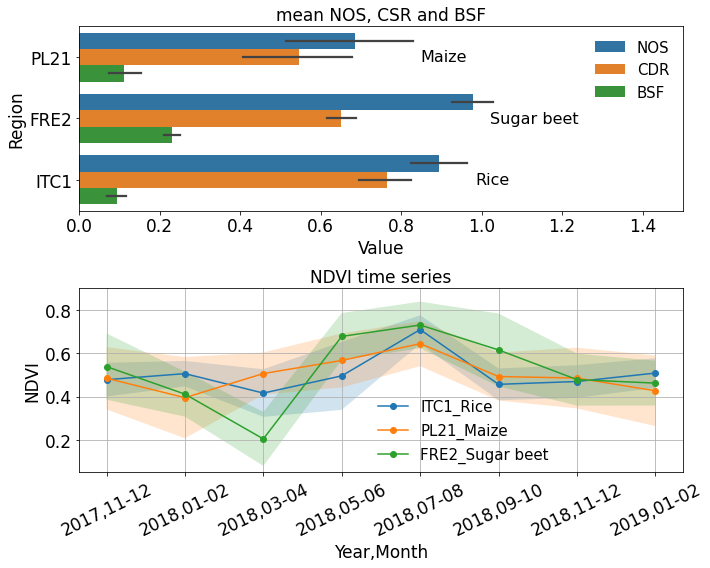

In [59]:

fig, axs = plt.subplots(2, 1, figsize=(10, 8))
sns.barplot(data=other_crop, y='nuts2', x='Value', hue='Index', ax=axs[0])
axs[0].set_title('mean NOS, CSR and BSF', fontsize=17)
axs[0].set_ylabel('Region', fontsize=17)
axs[0].set_xlabel('Value', fontsize=17)
axs[0].tick_params(axis='x', labelsize=17)
axs[0].tick_params(axis='y', labelsize=17)
axs[0].legend(fontsize=15, framealpha=0)
axs[0].set_xlim([0, 1.5])
axs[0].tick_params(labelsize=17)

grouped = other_crop.groupby('nuts2')['Value'].mean().reset_index()  # Find the maximum value for each group
for _, row in grouped.iterrows():
    # Find the corresponding crop for the 'nuts2' group. Assuming first match is representative for the group
    crop_label = other_crop[other_crop['nuts2'] == row['nuts2']]['lc1_label'].iloc[0]
    axs[0].text(row['Value']+0.4, row['nuts2'], crop_label, ha='left', va='center', fontsize=16, color='black')

    
# for na in ['ITC1_Rice', 'PL21_Maize', 'FRE2_Sugar beet']:
#     axs[1].errorbar(time_series['date'], (time_series[f'{na}_mean'] - 125) * 0.008, yerr=time_series[f'{na}_std'] * 0.008, fmt='-o', label=na)
for na in ['ITC1_Rice', 'PL21_Maize', 'FRE2_Sugar beet']:
    mean = (time_series[f'{na}_mean'] - 125) * 0.008
    std_dev = time_series[f'{na}_std'] * 0.008
    axs[1].plot(time_series['date'], mean, '-o', label=na)
    axs[1].fill_between(time_series['date'], mean - std_dev, mean + std_dev, alpha=0.2)
axs[1].set_xlabel('Year,Month',fontsize=17)
axs[1].set_ylabel('NDVI',fontsize=17)
axs[1].set_title('NDVI time series',fontsize=17)
axs[1].tick_params(labelsize=17)
axs[1].tick_params(axis='x',rotation=26)
axs[1].grid(True)
axs[1].legend(fontsize=15, bbox_to_anchor=(0.8,0.47), framealpha=0)#
axs[1].set_ylim([0.05, 0.9])

plt.tight_layout()
plt.savefig('/mnt/inca/tillage_index/007_different.crops.svg')
plt.show()


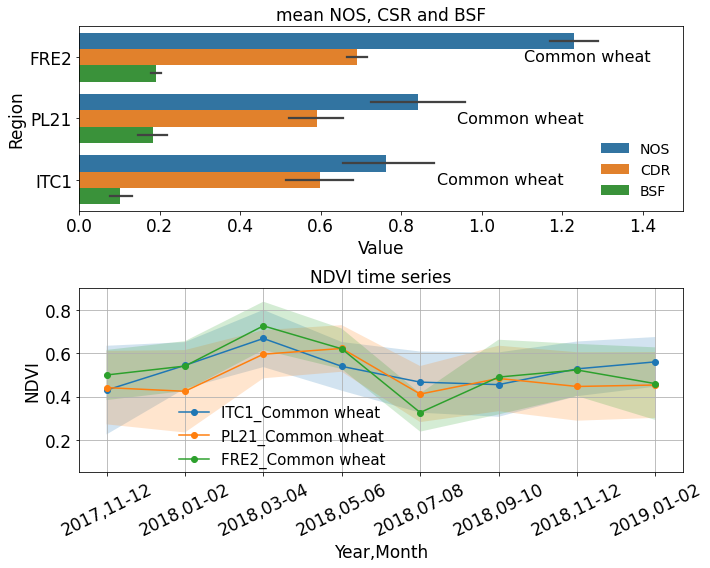

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

sns.barplot(data=wheat, y='nuts2', x='Value', hue='Index', ax=axs[0])
axs[0].set_title('mean NOS, CSR and BSF', fontsize=17)
axs[0].set_ylabel('Region', fontsize=17)
axs[0].set_xlabel('Value', fontsize=17)
axs[0].tick_params(axis='both', labelsize=17)
axs[0].legend(fontsize=14, framealpha=0)
axs[0].set_xlim([0, 1.5])

grouped = wheat.groupby('nuts2')['Value'].mean().reset_index()  # Find the maximum value for each group
for _, row in grouped.iterrows():
    # Find the corresponding crop for the 'nuts2' group. Assuming first match is representative for the group
    crop_label = wheat[wheat['nuts2'] == row['nuts2']]['lc1_label'].iloc[0]
    axs[0].text(row['Value']+0.4, row['nuts2'], crop_label, ha='left', va='center', fontsize=16, color='black')
    
# for na in ['ITC1_Common wheat', 'PL21_Common wheat', 'FRE2_Common wheat']:
#     axs[1].errorbar(time_series['date'], (time_series[f'{na}_mean'] - 125) * 0.008, yerr=time_series[f'{na}_std'] * 0.008, fmt='-o', label=na)

for na in ['ITC1_Common wheat', 'PL21_Common wheat', 'FRE2_Common wheat']:
    mean = (time_series[f'{na}_mean'] - 125) * 0.008
    std_dev = time_series[f'{na}_std'] * 0.008
    axs[1].plot(time_series['date'], mean, '-o', label=na)
    axs[1].fill_between(time_series['date'], mean - std_dev, mean + std_dev, alpha=0.2)

axs[1].set_xlabel('Year,Month',fontsize=17)
axs[1].set_ylabel('NDVI',fontsize=17)
axs[1].set_title('NDVI time series',fontsize=17)
axs[1].tick_params(axis='x', rotation=26)
axs[1].tick_params(labelsize=17)
axs[1].grid(True)
axs[1].legend(fontsize=15, bbox_to_anchor=(0.53,0.44), framealpha=0)#
axs[1].set_ylim([0.05, 0.9])


# Adjust layout and save the combined plot
plt.tight_layout()
plt.savefig('/mnt/inca/tillage_index/008_common.wheat.svg')
plt.show()


### visualize the point distribution

In [27]:
dft['name'] = dft['nuts2'] + '-' + dft['lc1_label']
different_crops = dft.loc[dft['name'].isin(['ITC1-Rice', 'PL21-Maize', 'FRE2-Sugar beet'])]
common_wheat = dft.loc[dft['name'].isin(['ITC1-Common wheat', 'PL21-Common wheat', 'FRE2-Common wheat'])]
different_crops.to_file('008_vis_different.crops.gpkg',driver='GPKG')
common_wheat.to_file('009_vis_common.wheat.gpkg',driver='GPKG')

In [2]:
# df = pd.read_csv('/mnt/inca/tillage_index/validate_data/LUCAS_lulc/004_vld_lucas.lulc.csv', low_memory=False)
# geometry = [Point(xy) for xy in zip(df['gps_long'], df['gps_lat'])]
# df = gpd.GeoDataFrame(df, geometry=geometry, crs='4326')
# df = df.to_crs('epsg:3035')

# df_ag = df.loc[df['nuts2'].isin(['ITC1','PL21','FRE2'])] #,'EL61','NL23'
# key = 'Agriculture (excluding fallow land and kitchen gardens)'
# kl_one_pixel = []
# for i in df_ag['point_id'].unique():
#     temp = df_ag.loc[df_ag['point_id']==i]
#     if (len(temp)>3) & (len(temp['trend-ndvi.p50'].unique())==1) & (len(temp['trend-bs.p50'].unique())==1):
#         kl_one_pixel.append(i)
        
# df_ag = df_ag.loc[(df_ag['lc1_class']=='B')&(df_ag['year']==2018)]

# for n in ['ITC1','PL21','FRE2']:
#     ttt = df_ag.loc[df_ag['nuts2']==n]
    
#     value_counts = ttt['lc1_label'].value_counts()
#     sorted_counts = value_counts.sort_values(ascending=False)
#     print(n,sorted_counts[0:3])
    
# df_ag = df_ag.loc[df_ag['lc1_label'].isin(['Sugar beet','Rice','Common wheat','Maize','Rape and turnip rape'])] # 
# df_ag.to_file('/mnt/inca/tillage_index/validate_data/LUCAS_lulc/001_tmp_check.ag.eg.gpkg',driver='GPKG')

# from eumap.misc import find_files, nan_percentile, GoogleSheet
# from eumap.raster import read_rasters, save_rasters
# from eumap.mapper import SpaceOverlay
# from pathlib import Path

# files = ['http://192.168.1.30:8333/ai4sh/ndvi/ndvi_glad.landsat.seasconv_m_30m_s_20171101_20171231_eu_epsg.3035_v20231127.tif',
#           'http://192.168.1.30:8333/ai4sh/ndvi/ndvi_glad.landsat.seasconv_m_30m_s_20180101_20180228_eu_epsg.3035_v20231127.tif',
#           'http://192.168.1.30:8333/ai4sh/ndvi/ndvi_glad.landsat.seasconv_m_30m_s_20180301_20180430_eu_epsg.3035_v20231127.tif',
#           'http://192.168.1.30:8333/ai4sh/ndvi/ndvi_glad.landsat.seasconv_m_30m_s_20180501_20180630_eu_epsg.3035_v20231127.tif',
#           'http://192.168.1.30:8333/ai4sh/ndvi/ndvi_glad.landsat.seasconv_m_30m_s_20180701_20180831_eu_epsg.3035_v20231127.tif',
#           'http://192.168.1.30:8333/ai4sh/ndvi/ndvi_glad.landsat.seasconv_m_30m_s_20180901_20181031_eu_epsg.3035_v20231127.tif',
#           'http://192.168.1.30:8333/ai4sh/ndvi/ndvi_glad.landsat.seasconv_m_30m_s_20181101_20181231_eu_epsg.3035_v20231127.tif',
#           'http://192.168.1.30:8333/ai4sh/ndvi/ndvi_glad.landsat.seasconv_m_30m_s_20190101_20190228_eu_epsg.3035_v20231127.tif']
# names = ['2017-11,12','2018-01,02','2018-03,04','2018-05,06','2018-07,08','2018-09,10','2018-11,12','2019-01,02']

# fnames = [i.split('/')[-1][0:-4] for i in files]
# name_map = dict(zip(fnames,names))
# files = [Path(i) for i in files]

# dfo = SpaceOverlay('/mnt/inca/tillage_index/validate_data/LUCAS_lulc/001_tmp_check.ag.eg.gpkg', fn_layers=files, max_workers=50, verbose=False)
# dft = dfo.run()
# dft = dft.rename(columns=name_map)
# dft = dft.drop(columns='overlay_id')
# dft.to_file(f'/mnt/inca/tillage_index/validate_data/005_vld_zoom.eg.crop.stat.gpkg', driver='GPKG')    



ITC1 lc1_label
Maize           122
Rice             85
Common wheat     84
Name: count, dtype: int64
PL21 lc1_label
Common wheat    95
Maize           35
Barley          20
Name: count, dtype: int64
FRE2 lc1_label
Common wheat            412
Sugar beet              178
Rape and turnip rape    126
Name: count, dtype: int64


In [ ]:
# df_crop = df.loc[(df['lc1_class']=='B') & (df['lu1']=='U111')]
# df_flevo = df_crop.loc[df['nuts2']=='NL23']
# df_flevo_key = df_flevo.loc[df_flevo['lc1_label'].isin(['Common wheat', 'Maize', 'Potatoes', 'Sugar beet'])]

# flevoland_sample = df_flevo_key.sort_values('gps_lat').loc[df_flevo_key['year']==2018][['nos','csr','bs','lc1_label','year','gps_lat','gps_long','point_id','geometry']]
# flevoland_sample = flevoland_sample.loc[flevoland_sample['csr']>0] # drop points that fall on road through visual examination

# flevoland_point = flevoland_sample.iloc[[19,21,22,31]]
# flevoland_sample.to_file(f'/mnt/inca/tillage_index/validate_data/LUCAS_lulc/002_tmp_flevoland.eg.gpkg',driver='GPKG')
# flevoland_point.to_file(f'/mnt/inca/tillage_index/validate_data/LUCAS_lulc/005_vld_flevoland.point.gpkg',driver='GPKG')

# df_flevo_key = df_flevo_key.rename(columns={'bs':'BSF'})
# df_flevo_key = df_flevo_key.rename(columns={'nos':'NOS'}) #
# df_flevo_key = df_flevo_key.rename(columns={'csr':'CSR'}) #
# df_flevo_key['CSR'] = df_flevo_key['CSR']/100
# df_flevo_key['BSF'] = df_flevo_key['BSF']/100
# melted_df = df_flevo_key.melt(id_vars='lc1_label', 
#                               value_vars=['NOS', 'CSR', 'BSF'], 
#                               var_name='Index', 
#                               value_name='Value')
# fig, ax = plt.subplots(figsize=(12,4))
# # plt.figure(figsize=(12, 4))
# sns.barplot(data=melted_df, y='lc1_label', x='Value', hue='Index')

# plt.title('Comparison of NOS, CSR and BSF across crop types', fontsize=16)
# plt.ylabel('Crop type', fontsize=14)
# plt.xlabel('Value', fontsize=14)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.legend(title='Index')
# ax.set_xlim([0,1.2]) # 
# # following line will save the plot as a svg file
# plt.tight_layout() # removes the whitespace around the graph
# plt.savefig('bar_chart.svg') # let save this poor graph
# # after save you can display again other way not works unfortunatelly.
# plt.show()